In [36]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import matplotlib as mpl

from scipy import optimize, stats

In [37]:
plt.rcParams["axes.linewidth"]  = 1.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=13)

if os.environ['USER'] == 'dhayaa':
    os.environ['PATH'] = f"{os.environ['PATH']}:/software/texlive-2022-el8-x86_64/bin/x86_64-linux/"


COLORS = ["f07167","219ebc","c767ac","E0A100","59a270"]
COLORS = ['#' + c if c[0] != '#' else c for c in COLORS ]

from cycler import cycler

# Update the default prop_cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=COLORS)

# Load tables

In [38]:
def combine(X):
    
    return np.concatenate([np.concatenate([X_i[:, 3], X_i[:, 4]]) for X_i in X])

def split_array(arr):
    
    splits = [arr[i:i+50] for i in range(0, len(arr), 50)]  # split the array into 50-point chunks
    
    return splits

def cov_to_corr(cov):
    
    return cov/np.outer(np.sqrt(np.diagonal(cov)), np.sqrt(np.diagonal(cov)))

In [39]:
def DO_FIT(DIR, Force_Rerun = False):
    
    CHAIN_FILE = DIR + '/ABE_Fit_Params.npy'
    
    if os.path.isfile(CHAIN_FILE) & (Force_Rerun == False):
        
        print("FOUND EXISTING CHAIN. LOADING FILE")
        
        X = np.load(CHAIN_FILE, allow_pickle = True)[()]
        
        a_median, b_median, c_median = np.median(X['samples'], axis=0)
        a_err = np.percentile(X['samples'][:, 0], [16, 84]) - a_median
        b_err = np.percentile(X['samples'][:, 1], [16, 84]) - b_median
        c_err = np.percentile(X['samples'][:, 2], [16, 84]) - c_median

        print("----------------------------------")
        print("----------------------------------")
        print(DIR)
        print("a = {:.4f} +/- {:.4f}".format(a_median, np.mean(np.abs(a_err))))
        print("b = {:.4f} +/- {:.4f}".format(b_median, np.mean(np.abs(b_err))))
        print("c = {:.4f} +/- {:.4f}".format(c_median, np.mean(np.abs(c_err))))
        print("----------------------------------")
        print("Best-fit parameters:", X['bf'])
        print("CHI2:", X['bf_chi2'])
        
        return X['bf'], X['samples']
    
    cov = np.loadtxt(DIR + '/taustats_All_cov_treecorr.txt')
    cov = cov[50:, 50:] #Remove shear block

    tau_cov = cov[-150:, -150:]
    inv_tau_cov = np.linalg.inv(tau_cov)
    
    tau0_cov = cov[-150:-100,-150:-100]
    tau1_cov = cov[-100:-50, -100:-50]
    tau2_cov = cov[-50:,-50:]
    
    tau = cov[-150:, -150:]
    
    m_p = np.concatenate([np.arange(25), 50 + np.arange(25), 50*2 + np.arange(25)])
    m_m = np.concatenate([25 + np.arange(25), 25 + 50 + np.arange(25), 25 + 50*2 + np.arange(25)])
    
    tau_p = tau[m_p].T[m_p]
    tau_m = tau[m_m].T[m_m]

    NJK = 150
    hartlap  = (NJK - 75)/(NJK -1)
    dodelson = 1 / (1 + (75 - 3) * (NJK - 75 - 2) / (NJK - 75 - 1) / (NJK - 75 - 4) )
    
    print(hartlap, dodelson, hartlap * dodelson)
    
    
    inv_taup_cov = np.linalg.inv(tau_p) * hartlap * dodelson
    inv_taum_cov = np.linalg.inv(tau_m) * hartlap * dodelson

    datavectors = [np.loadtxt(DIR +'/taustats_shear_2pt_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho0_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho1_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho2_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho3_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho4_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho5_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau0_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau1_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau2_treecorr.txt')]

    combined = combine(datavectors[:])

    mean = combined[50:]

    splits = split_array(mean)

    import emcee

    tau_data = np.concatenate(splits[-3:])

    # Define the log-likelihood function
    def log_likelihood(theta):

        alpha, beta, eta = theta
        
        rho0, rho1, rho2, rho3, rho4, rho5, tau0, tau1, tau2 = splits

        tau0_model = alpha*rho0 + beta*rho2 + eta*rho5
        tau1_model = alpha*rho2 + beta*rho1 + eta*rho4
        tau2_model = alpha*rho5 + beta*rho4 + eta*rho3

        diff0 = tau0 - tau0_model
        diff1 = tau1 - tau1_model
        diff2 = tau2 - tau2_model
        
        diff_p = np.concatenate([d[:25] for d in [diff0,diff1,diff2]])
        diff_m = np.concatenate([d[25:] for d in [diff0,diff1,diff2]])

        chi2 = (diff_p @ inv_taup_cov @ diff_p + 
                diff_m @ inv_taum_cov @ diff_m)

        return -chi2

    # Define the log-prior function
    def log_prior(theta):
        # Set uniform priors for a, b, c between -10 and 10
        if (-10 < theta[0] < 10) and (-10 < theta[1] < 10) and (-10 < theta[2] < 10):
            return 0.0
        else:
            return -np.inf

    # Define the log-posterior function
    def log_posterior(theta):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta)

    # Set up the emcee sampler
    ndim = 3
    nwalkers = 100
    pos = np.random.multivariate_normal([0.001, 1, -1], cov = np.diag([0.01, 0.5, 0.1])**2, size = nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

    # Burn in the sampler
    pos, _, _ = sampler.run_mcmc(pos, 1000, progress = True)

    # Run the sampler for 1000 steps
    sampler.reset()
    sampler.run_mcmc(pos, 2000, progress = True)

    # Get the samples and flatten the chains
    samples = sampler.chain[:, :, :].reshape((-1, ndim))

#     OUT[DIR] = samples

    # Print the median and 1-sigma uncertainties of a, b, c
    a_median, b_median, c_median = np.median(samples, axis=0)
    a_err = np.percentile(samples[:, 0], [16, 84]) - a_median
    b_err = np.percentile(samples[:, 1], [16, 84]) - b_median
    c_err = np.percentile(samples[:, 2], [16, 84]) - c_median

    print("----------------------------------")
    print("----------------------------------")
    print(DIR)
    print("a = {:.4f} +/- {:.4f}".format(a_median, np.mean(np.abs(a_err))))
    print("b = {:.4f} +/- {:.4f}".format(b_median, np.mean(np.abs(b_err))))
    print("c = {:.4f} +/- {:.4f}".format(c_median, np.mean(np.abs(c_err))))
    print("----------------------------------")

    # Find the index of the maximum log-probability
    max_log_prob_index = np.argmax(sampler.flatlnprobability)
    # Retrieve the corresponding sample
    best_fit_params = sampler.flatchain[max_log_prob_index]

    print("Best-fit parameters:", best_fit_params)

    chi2 = -log_likelihood(best_fit_params)
    print("CHI2:", chi2)
    
    OUT = {'bf' : best_fit_params, 'samples' : samples, "bf_chi2" : chi2}
    
    np.save(CHAIN_FILE, OUT, allow_pickle = True)
    return best_fit_params, samples

In [40]:
import glob
MAIN = []
for DIR in sorted(glob.glob('/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_*/')):

    best_fit_params, samples = DO_FIT(DIR, Force_Rerun = True)
    
    MAIN.append(samples)

    a_median, b_median, c_median = np.median(samples, axis=0)
    a_err = np.percentile(samples[:, 0], [16, 84]) - a_median
    b_err = np.percentile(samples[:, 1], [16, 84]) - b_median
    c_err = np.percentile(samples[:, 2], [16, 84]) - c_median

0.5033557046979866 0.49990485252140815 0.2516299593228565


100%|██████████| 2000/2000 [00:05<00:00, 349.30it/s]


----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_-999/
a = 0.0001 +/- 0.0029
b = 1.4901 +/- 0.0681
c = -3.1303 +/- 0.9305
----------------------------------
Best-fit parameters: [ 8.51328935e-05  1.48885180e+00 -3.14987485e+00]
CHI2: 205.63427074004767
0.5033557046979866 0.49990485252140815 0.2516299593228565


100%|██████████| 2000/2000 [00:05<00:00, 351.16it/s]


----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_1/
a = -0.0054 +/- 0.0044
b = 1.5462 +/- 0.1136
c = -0.2501 +/- 1.4381
----------------------------------
Best-fit parameters: [-0.00546378  1.54265137 -0.29579022]
CHI2: 128.52160842793103
0.5033557046979866 0.49990485252140815 0.2516299593228565


100%|██████████| 2000/2000 [00:05<00:00, 354.42it/s]


----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_1_Npatch500/
a = 0.0025 +/- 0.0070
b = 1.6347 +/- 0.1630
c = -0.8548 +/- 2.2794
----------------------------------
Best-fit parameters: [ 0.00222851  1.63462017 -0.93054436]
CHI2: 53.90985527252066
0.5033557046979866 0.49990485252140815 0.2516299593228565


100%|██████████| 2000/2000 [00:05<00:00, 381.73it/s]


----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_2/
a = -0.0101 +/- 0.0052
b = 1.7761 +/- 0.1185
c = -8.0345 +/- 1.5160
----------------------------------
Best-fit parameters: [-0.01221994  1.75560574 -8.72870123]
CHI2: 130.6262137218442
0.5033557046979866 0.49990485252140815 0.2516299593228565


100%|██████████| 2000/2000 [00:05<00:00, 379.22it/s]


----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_2_Npatch500/
a = -0.0136 +/- 0.0077
b = 1.7490 +/- 0.1890
c = -7.2707 +/- 2.0824
----------------------------------
Best-fit parameters: [-0.01602799  1.73039115 -8.0719173 ]
CHI2: 77.69865713671723
0.5033557046979866 0.49990485252140815 0.2516299593228565


100%|██████████| 2000/2000 [00:05<00:00, 355.81it/s]


----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_3/
a = -0.0094 +/- 0.0063
b = 1.9174 +/- 0.1256
c = -3.8189 +/- 1.9547
----------------------------------
Best-fit parameters: [-0.00924214  1.91989293 -3.81401186]
CHI2: 110.1591312714195
0.5033557046979866 0.49990485252140815 0.2516299593228565


100%|██████████| 2000/2000 [00:05<00:00, 363.20it/s]


----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_3_Npatch500/
a = -0.0058 +/- 0.0100
b = 1.6712 +/- 0.1818
c = -2.8773 +/- 2.9182
----------------------------------
Best-fit parameters: [-0.00584013  1.66821426 -2.92404288]
CHI2: 52.26592321023311
0.5033557046979866 0.49990485252140815 0.2516299593228565


100%|██████████| 2000/2000 [00:05<00:00, 359.84it/s]


----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_4/
a = 0.0028 +/- 0.0063
b = 2.0374 +/- 0.1619
c = 4.1067 +/- 2.0818
----------------------------------
Best-fit parameters: [2.89538108e-03 2.04132355e+00 4.19270242e+00]
CHI2: 174.94606298030294
0.5033557046979866 0.49990485252140815 0.2516299593228565


100%|██████████| 2000/2000 [00:05<00:00, 350.41it/s]

----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_4_Npatch500/
a = -0.0015 +/- 0.0107
b = 1.8128 +/- 0.2270
c = 0.8296 +/- 3.0527
----------------------------------
Best-fit parameters: [-1.46883580e-03  1.81950975e+00  8.73590069e-01]
CHI2: 62.10934158382126


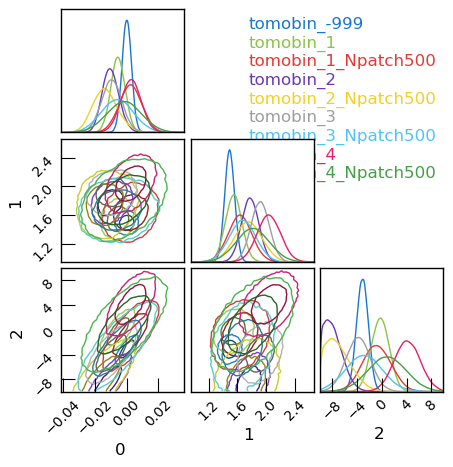

In [41]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
for i in range(len(MAIN)):
    c.add_chain(MAIN[i], name = DIRS[i].split(r'/')[-2])

c.plotter.plot();

# Check fit

In [ ]:
for i in range(len(DIRs)):
    
    DIR = DIRs[i]
    M   = MAIN[i]
    fig, ax = plt.subplots(2, 3, figsize = (15, 6), sharex = True)

    plt.subplots_adjust(hspace = 0.05, wspace = 0.25)

    [a.set_xscale('log') for a in ax.flatten()]
    # [a.set_yscale('log') for a in ax.flatten()]

    x = np.loadtxt(DIR + 'taustats_tau%d_treecorr.txt' % 0)

    datavectors = [np.loadtxt(DIR +'/taustats_shear_2pt_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho0_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho1_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho2_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho3_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho4_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho5_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau0_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau1_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau2_treecorr.txt')]


    a, b, c = np.median(M, axis = 0)
    cc = [1e-6, 1e-6, 1e-6, 1e-7, 1e-7, 1e-8]
    cc = [a**2, a*b, b**2, a*e, a*b, e*e]
    f = x[:, 0]

    ax.flatten()[0].scatter(x[:, 0], 1/cc[0]*np.abs(x[:, 3]), s=13, color = COLORS[0], label = 'Data')
    ax.flatten()[0].errorbar(x[:, 0], 1/cc[0]*np.abs(x[:, 3]), yerr = 1/cc[0]*x[:, 7], fmt = 'none', color = COLORS[0], lw = 0, elinewidth = 1)

    ax.flatten()[0 + 3].scatter(x[:, 0], 1/cc[1]*np.abs(x[:, 4]), s=13, color = COLORS[0])
    ax.flatten()[0 + 3].errorbar(x[:, 0], 1/cc[1]*np.abs(x[:, 4]), yerr = 1/cc[1]*x[:, 8], fmt = 'none', color = COLORS[0], lw = 0, elinewidth = 1)


    x = np.loadtxt(DIR + 'taustats_tau%d_treecorr.txt' % 1)
    ax.flatten()[1].scatter(x[:, 0],  1/cc[2]*f*np.abs(x[:, 3]), s=13, color = COLORS[0])
    ax.flatten()[1].errorbar(x[:, 0], 1/cc[2]*f*np.abs(x[:, 3]), yerr = 1/cc[2]*f*x[:, 7], fmt = 'none', color = COLORS[0], lw = 0, elinewidth = 1, label = 'Data')

    ax.flatten()[1 + 3].scatter(x[:, 0],  1/cc[3]*f*np.abs(x[:, 4]), s=13, color = COLORS[0])
    ax.flatten()[1 + 3].errorbar(x[:, 0], 1/cc[3]*f*np.abs(x[:, 4]), yerr = 1/cc[3]*f*x[:, 8], fmt = 'none', color = COLORS[0], lw = 0, elinewidth = 1)

    x = np.loadtxt(DIR + 'taustats_tau%d_treecorr.txt' % 2)
    ax.flatten()[2].scatter(x[:, 0],  1/cc[4]*np.abs(x[:, 3]), s=13, color = COLORS[0])
    ax.flatten()[2].errorbar(x[:, 0], 1/cc[4]*np.abs(x[:, 3]), yerr = 1/cc[4]*x[:, 7], fmt = 'none', color = COLORS[0], lw = 0, elinewidth = 1, label = 'Data')

    ax.flatten()[2 + 3].scatter(x[:, 0],  1/cc[5]*f*np.abs(x[:, 4]), s=13, color = COLORS[0])
    ax.flatten()[2 + 3].errorbar(x[:, 0], 1/cc[5]*f*np.abs(x[:, 4]), yerr = 1/cc[5]*f*x[:, 8], fmt = 'none', color = COLORS[0], lw = 0, elinewidth = 1)


    ax.flatten()[0].plot(x[:, 0], 1/cc[0]*np.abs(datavectors[1][:, 3] * a_median + 
                                         datavectors[3][:, 3] * b_median + 
                                         datavectors[6][:, 3] * c_median), color = 'grey', lw = 1, ls='--', alpha = 0.7, label = 'Fit', zorder = -1)

    ax.flatten()[3].plot(x[:, 0], 1/cc[1]*np.abs(datavectors[1][:, 4] * a_median + 
                                         datavectors[3][:, 4] * b_median + 
                                         datavectors[6][:, 4] * c_median), color = 'grey', lw = 1, ls='--', alpha = 0.7, zorder = -1)


    ax.flatten()[1].plot(x[:, 0], 1/cc[2]*f*np.abs(datavectors[3][:, 3] * a_median + 
                                         datavectors[2][:, 3] * b_median + 
                                         datavectors[5][:, 3] * c_median), color = 'grey', lw = 1, ls='--', alpha = 0.7, zorder = -1)

    ax.flatten()[4].plot(x[:, 0], 1/cc[3]*f*np.abs(datavectors[3][:, 4] * a_median + 
                                         datavectors[2][:, 4] * b_median + 
                                         datavectors[5][:, 4] * c_median), color = 'grey', lw = 1, ls='--', alpha = 0.7, zorder = -1)


    ax.flatten()[2].plot(x[:, 0], 1/cc[4]*np.abs(datavectors[6][:, 3] * a_median + 
                                         datavectors[5][:, 3] * b_median + 
                                         datavectors[4][:, 3] * c_median), color = 'grey', lw = 1, ls='--', alpha = 0.7, zorder = -1)

    ax.flatten()[5].plot(x[:, 0], 1/cc[5]*f*np.abs(datavectors[6][:, 4] * a_median + 
                                         datavectors[5][:, 4] * b_median + 
                                         datavectors[4][:, 4] * c_median), color = 'grey', lw = 1, ls='--', alpha = 0.7, zorder = -1)

    for i, l in enumerate([r'$|\tau_0^+| = |\langle \rm \gamma^{\rm est} p\rangle|$  [$10^{-6}$]',
                           r'$|\theta\tau_1^+| = |\theta\langle \rm \gamma^{\rm est} q\rangle|$  [$10^{-6}$]',
                           r'$|\tau_2^+| = |\langle \rm \gamma^{\rm est} w\rangle|$  [$10^{-7}$]',
                           r'$|\tau_0^-| = |\langle \rm \gamma^{\rm est} p\rangle|$  [$10^{-6}$]',
                           r'$|\theta\tau_1^-| = |\theta\langle \rm \gamma^{\rm est} q\rangle|$  [$10^{-7}$]',
                           r'$|\theta\tau_2^-| = |\theta\langle \rm \gamma^{\rm est} w\rangle|$  [$10^{-8}$]']):
        ax.flatten()[i].set_ylabel(r'%s' % l, size = 14, labelpad = 3)

    ax.flat[0].legend(fontsize = 14, frameon = False, ncol = 2)
    [ax.flatten()[i].set_xlabel(r'$\theta$ [arcmin]', size = 14) for i in [3, 4, 5]];

    [a.tick_params(pad = 10) for a in ax.flat]
    plt.show()

# Check sensitivity to SNR cut

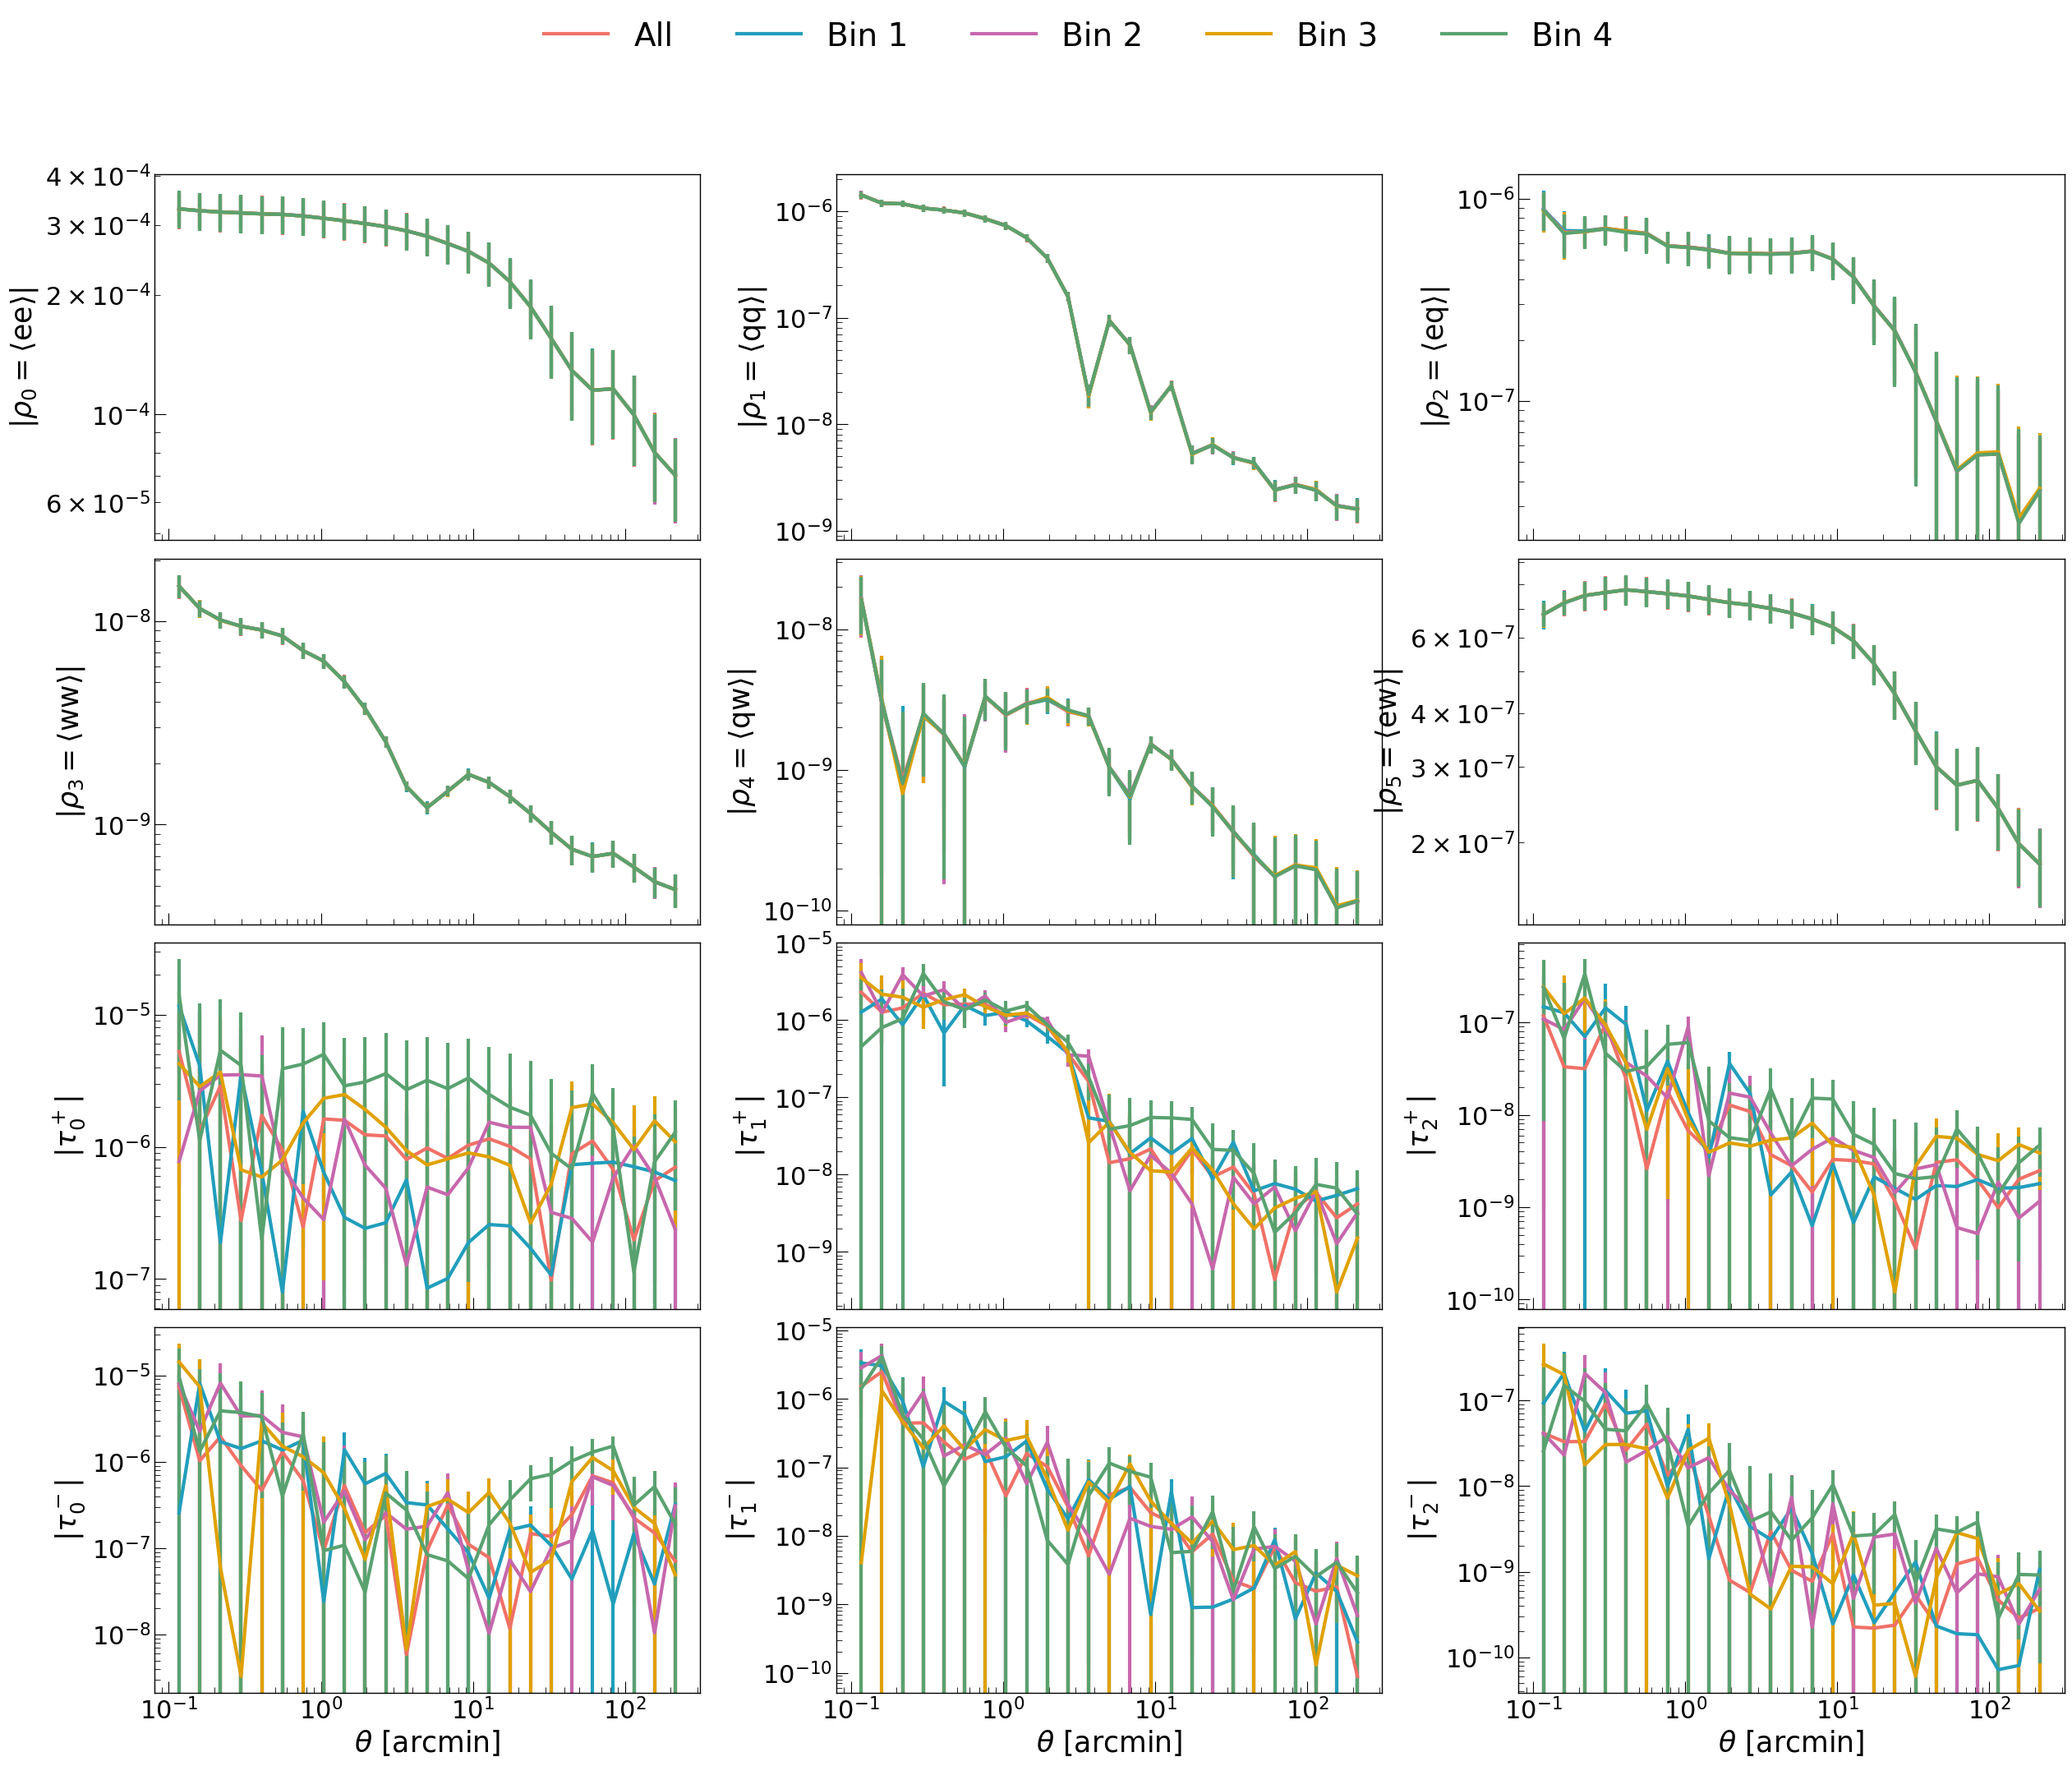

In [9]:
plt.rc("font", size=22)

fig, ax = plt.subplots(4, 3, figsize = (30, 24), sharex = True)

plt.subplots_adjust(hspace = 0.05, wspace = 0.25)

[a.loglog() for a in ax.flatten()]

paths = ['/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_-999/',
         '/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_1/',
         '/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_2/',
         '/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_3/',
         '/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_4/',]

for p in paths:
    
    
    for i in range(6):

        x = np.loadtxt(p + '/taustats_rho%d_treecorr.txt' % i)
        ax.flatten()[i].errorbar(x[:, 0], np.abs(x[:, 3]), yerr = x[:, 7], lw = 3)

    for i in range(3):
    
        x = np.loadtxt(p + 'taustats_tau%d_treecorr.txt' % i)
        ax.flatten()[6 + i].errorbar(x[:, 0], np.abs(x[:, 3]), yerr = x[:, 7], lw = 3)
        ax.flatten()[6 + i + 3].errorbar(x[:, 0], np.abs(x[:, 4]), yerr = x[:, 8], lw = 3)

    
fig.legend([plt.plot([], [], lw = 3, color = 'C%d' % i)[0] for i in range(len(paths))], 
           [r'All', r'Bin 1', r'Bin 2',  r'Bin 3', r'Bin 4',],
           loc = 'center', ncol = 5, bbox_to_anchor = (0.5, 0.95), fontsize = 28, frameon = False)

for i, l in enumerate([r'\rho_0 = \langle {\rm ee} \rangle',
                       r'\rho_1 = \langle {\rm qq} \rangle',
                       r'\rho_2 = \langle {\rm eq} \rangle',
                       r'\rho_3 = \langle {\rm ww} \rangle',
                       r'\rho_4 = \langle {\rm qw} \rangle',
                       r'\rho_5 = \langle {\rm ew} \rangle'] + 
                      [r'\tau_0^+',
                       r'\tau_1^+',
                       r'\tau_2^+',
                       r'\tau_0^-',
                       r'\tau_1^-',
                       r'\tau_2^-']):
    ax.flatten()[i].set_ylabel(r'$|%s|$' % l, size = 25)
    
[ax.flatten()[i].set_xlabel(r'$\theta$ [arcmin]', size = 25) for i in [9, 10,  11]];

# ax.flatten()[0].set_ylim(7e-5, 1e-3)
# ax.flatten()[1].set_ylim(2e-9, 4e-6)
# ax.flatten()[2].set_ylim(1e-7, 2.5e-6)

# ax.flatten()[4].set_ylim(5e-10, 3.5e-8)
# ax.flatten()[5].set_ylim(9e-8, 2e-6)

# Variant for fitting technique

In [10]:
def DO_FIT_V2(DIR):
    
    cov = np.loadtxt(DIR + '/taustats_All_cov_treecorr.txt')
    cov = cov[50:, 50:] #Remove shear block

    tau_cov = cov[-150:, -150:]
    inv_tau_cov = np.linalg.inv(tau_cov)
    
    tau0_cov = cov[-150:-100,-150:-100]
    tau1_cov = cov[-100:-50, -100:-50]
    tau2_cov = cov[-50:,-50:]

    NJK = 150
    hartlap  = (NJK - 50)/(NJK -1)
    dodelson = 1 / (1 + (50 - 3) * (NJK - 50 - 2) / (NJK - 50 - 1) / (NJK - 50 - 4) )
    
    print(hartlap, dodelson, hartlap * dodelson)
    
    inv_tau0_cov = np.linalg.inv(tau0_cov) * hartlap * dodelson
    inv_tau1_cov = np.linalg.inv(tau1_cov) * hartlap * dodelson
    inv_tau2_cov = np.linalg.inv(tau2_cov) * hartlap * dodelson

    datavectors = [np.loadtxt(DIR +'/taustats_shear_2pt_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho0_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho1_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho2_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho3_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho4_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho5_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau0_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau1_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau2_treecorr.txt')]

    combined = combine(datavectors[:])

    mean = combined[50:]

    splits = split_array(mean)

    import emcee

    tau_data = np.concatenate(splits[-3:])

    # Define the log-likelihood function
    def log_likelihood(theta):

        alpha, beta, eta = theta

        rho0, rho1, rho2, rho3, rho4, rho5, tau0, tau1, tau2 = splits

        tau0_model = alpha*rho0 + beta*rho2 + eta*rho5
        tau1_model = alpha*rho2 + beta*rho1 + eta*rho4
        tau2_model = alpha*rho5 + beta*rho4 + eta*rho3

        diff0 = tau0 - tau0_model
        diff1 = tau1 - tau1_model
        diff2 = tau2 - tau2_model

        chi2 = (diff0 @ inv_tau0_cov @ diff0 + 
                diff1 @ inv_tau1_cov @ diff1 + 
                diff2 @ inv_tau2_cov @ diff2)

        return -chi2

    # Define the log-prior function
    def log_prior(theta):
        # Set uniform priors for a, b, c between -10 and 10
        if (-10 < theta[0] < 10) and (-10 < theta[1] < 10) and (-10 < theta[2] < 10):
            return 0.0
        else:
            return -np.inf

    # Define the log-posterior function
    def log_posterior(theta):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta)

    # Set up the emcee sampler
    ndim = 3
    nwalkers = 100
    pos = np.random.multivariate_normal([0.001, 1, -1], cov = np.diag([0.01, 0.5, 0.1])**2, size = nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

    # Burn in the sampler
    pos, _, _ = sampler.run_mcmc(pos, 1000, progress = True)

    # Run the sampler for 1000 steps
    sampler.reset()
    sampler.run_mcmc(pos, 2000, progress = True)

    # Get the samples and flatten the chains
    samples = sampler.chain[:, :, :].reshape((-1, ndim))

#     OUT[DIR] = samples

    # Print the median and 1-sigma uncertainties of a, b, c
    a_median, b_median, c_median = np.median(samples, axis=0)
    a_err = np.percentile(samples[:, 0], [16, 84]) - a_median
    b_err = np.percentile(samples[:, 1], [16, 84]) - b_median
    c_err = np.percentile(samples[:, 2], [16, 84]) - c_median

    print("----------------------------------")
    print("----------------------------------")
    print(DIR)
    print("a = {:.4f} +/- {:.4f}".format(a_median, np.mean(np.abs(a_err))))
    print("b = {:.4f} +/- {:.4f}".format(b_median, np.mean(np.abs(b_err))))
    print("c = {:.4f} +/- {:.4f}".format(c_median, np.mean(np.abs(c_err))))
    print("----------------------------------")

    # Find the index of the maximum log-probability
    max_log_prob_index = np.argmax(sampler.flatlnprobability)
    # Retrieve the corresponding sample
    best_fit_params = sampler.flatchain[max_log_prob_index]

    print("Best-fit parameters:", best_fit_params)

    chi2 = -log_likelihood(best_fit_params)
    print("CHI2:", chi2)
    
    return best_fit_params, samples


best_fit_params, samples = DO_FIT_V2(DIR)

a_median, b_median, c_median = np.median(samples, axis=0)
a_err = np.percentile(samples[:, 0], [16, 84]) - a_median
b_err = np.percentile(samples[:, 1], [16, 84]) - b_median
c_err = np.percentile(samples[:, 2], [16, 84]) - c_median

0.6711409395973155 0.6735648476257973 0.4520569447153002


100%|██████████| 2000/2000 [00:06<00:00, 331.84it/s]

----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_4/
a = -0.0168 +/- 0.0058
b = 2.2071 +/- 0.1744
c = -0.9754 +/- 1.9817
----------------------------------
Best-fit parameters: [-0.01687363  2.20589517 -0.92875745]
CHI2: 185.2051383170614


In [11]:
paths = ['/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_-999/',
         '/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_1/',
         '/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_2/',
         '/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_3/',
         '/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_4/',]

for p in paths:
    best_fit_params, samples = DO_FIT_V2(p)

    a_median, b_median, c_median = np.median(samples, axis=0)
    a_err = np.percentile(samples[:, 0], [16, 84]) - a_median
    b_err = np.percentile(samples[:, 1], [16, 84]) - b_median
    c_err = np.percentile(samples[:, 2], [16, 84]) - c_median

0.6711409395973155 0.6735648476257973 0.4520569447153002


100%|██████████| 2000/2000 [00:06<00:00, 324.38it/s]


----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_-999/
a = -0.0015 +/- 0.0028
b = 1.6644 +/- 0.0704
c = -2.1626 +/- 0.8810
----------------------------------
Best-fit parameters: [-1.42097357e-03  1.66335325e+00 -2.12929276e+00]
CHI2: 217.56489070742015
0.6711409395973155 0.6735648476257973 0.4520569447153002


100%|██████████| 2000/2000 [00:05<00:00, 336.68it/s]


----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_1/
a = -0.0159 +/- 0.0043
b = 1.5644 +/- 0.1022
c = -5.2777 +/- 1.5389
----------------------------------
Best-fit parameters: [-0.01594954  1.56128704 -5.30911282]
CHI2: 131.31997983681364
0.6711409395973155 0.6735648476257973 0.4520569447153002


100%|██████████| 2000/2000 [00:05<00:00, 383.40it/s]


----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_2/
a = -0.0169 +/- 0.0039
b = 1.7245 +/- 0.1199
c = -8.7111 +/- 1.1442
----------------------------------
Best-fit parameters: [-0.02039218  1.71373252 -9.94915763]
CHI2: 199.07225612630373
0.6711409395973155 0.6735648476257973 0.4520569447153002


100%|██████████| 2000/2000 [00:05<00:00, 375.91it/s]


----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_3/
a = -0.0022 +/- 0.0058
b = 1.9947 +/- 0.1144
c = -3.7843 +/- 1.8463
----------------------------------
Best-fit parameters: [-2.23994363e-03  1.99635610e+00 -3.80542526e+00]
CHI2: 121.85593717405946
0.6711409395973155 0.6735648476257973 0.4520569447153002


100%|██████████| 2000/2000 [00:05<00:00, 349.18it/s]

----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/tomobin_4/
a = -0.0169 +/- 0.0058
b = 2.2049 +/- 0.1715
c = -0.9722 +/- 1.9853
----------------------------------
Best-fit parameters: [-0.01677066  2.20536023 -0.88687746]
CHI2: 185.20544190716225


In [12]:
def DO_FIT_V2(DIR):
    
    cov = np.loadtxt(DIR + '/taustats_All_cov_treecorr.txt')
    cov = cov[50:, 50:] #Remove shear block

    tau_cov = cov[-150:, -150:]
    inv_tau_cov = np.linalg.inv(tau_cov)
    
    tau0_cov = cov[-150:-100,-150:-100]
    tau1_cov = cov[-100:-50, -100:-50]
    tau2_cov = cov[-50:,-50:]

    NJK = 150
    hartlap  = (NJK - 50)/(NJK -1)
    dodelson = 1 / (1 + (50 - 3) * (NJK - 50 - 2) / (NJK - 50 - 1) / (NJK - 50 - 4) )
    
    print(hartlap, dodelson, hartlap * dodelson)
    
    inv_tau0_cov = np.linalg.inv(tau0_cov) * hartlap * dodelson
    inv_tau1_cov = np.linalg.inv(tau1_cov) * hartlap * dodelson
    inv_tau2_cov = np.linalg.inv(tau2_cov) * hartlap * dodelson

    datavectors = [np.loadtxt(DIR +'/taustats_shear_2pt_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho0_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho1_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho2_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho3_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho4_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho5_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau0_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau1_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau2_treecorr.txt')]

    combined = combine(datavectors[:])

    mean = combined[50:]

    splits = split_array(mean)

    import emcee

    tau_data = np.concatenate(splits[-3:])

    # Define the log-likelihood function
    def log_likelihood(theta):

        alpha, beta, eta = theta

        rho0, rho1, rho2, rho3, rho4, rho5, tau0, tau1, tau2 = splits

        tau0_model = alpha*rho0 + beta*rho2 + eta*rho5
        tau1_model = alpha*rho2 + beta*rho1 + eta*rho4
        tau2_model = alpha*rho5 + beta*rho4 + eta*rho3

        diff0 = tau0 - tau0_model
        diff1 = tau1 - tau1_model
        diff2 = tau2 - tau2_model

        chi2 = (diff0 @ inv_tau0_cov @ diff0 + 
                diff1 @ inv_tau1_cov @ diff1 + 
                diff2 @ inv_tau2_cov @ diff2)

        return -chi2

    # Define the log-prior function
    def log_prior(theta):
        # Set uniform priors for a, b, c between -10 and 10
        if (-10 < theta[0] < 10) and (-10 < theta[1] < 10) and (-10 < theta[2] < 10):
            return 0.0
        else:
            return -np.inf

    # Define the log-posterior function
    def log_posterior(theta):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta)

    # Set up the emcee sampler
    ndim = 3
    nwalkers = 100
    pos = np.random.multivariate_normal([0.001, 1, -1], cov = np.diag([0.01, 0.5, 0.1])**2, size = nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

    # Burn in the sampler
    pos, _, _ = sampler.run_mcmc(pos, 1000, progress = True)

    # Run the sampler for 1000 steps
    sampler.reset()
    sampler.run_mcmc(pos, 2000, progress = True)

    # Get the samples and flatten the chains
    samples = sampler.chain[:, :, :].reshape((-1, ndim))

#     OUT[DIR] = samples

    # Print the median and 1-sigma uncertainties of a, b, c
    a_median, b_median, c_median = np.median(samples, axis=0)
    a_err = np.percentile(samples[:, 0], [16, 84]) - a_median
    b_err = np.percentile(samples[:, 1], [16, 84]) - b_median
    c_err = np.percentile(samples[:, 2], [16, 84]) - c_median

    print("----------------------------------")
    print("----------------------------------")
    print(DIR)
    print("a = {:.4f} +/- {:.4f}".format(a_median, np.mean(np.abs(a_err))))
    print("b = {:.4f} +/- {:.4f}".format(b_median, np.mean(np.abs(b_err))))
    print("c = {:.4f} +/- {:.4f}".format(c_median, np.mean(np.abs(c_err))))
    print("----------------------------------")

    # Find the index of the maximum log-probability
    max_log_prob_index = np.argmax(sampler.flatlnprobability)
    # Retrieve the corresponding sample
    best_fit_params = sampler.flatchain[max_log_prob_index]

    print("Best-fit parameters:", best_fit_params)

    chi2 = -log_likelihood(best_fit_params)
    print("CHI2:", chi2)
    
    return best_fit_params, samples


best_fit_params, samples = DO_FIT_V2(DIR)

a_median, b_median, c_median = np.median(samples, axis=0)
a_err = np.percentile(samples[:, 0], [16, 84]) - a_median
b_err = np.percentile(samples[:, 1], [16, 84]) - b_median
c_err = np.percentile(samples[:, 2], [16, 84]) - c_median

0.6711409395973155 0.6735648476257973 0.4520569447153002


100%|██████████| 2000/2000 [00:05<00:00, 373.45it/s]


----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20240901/FIDUCIAL/
a = -0.0021 +/- 0.0026
b = 1.4680 +/- 0.0732
c = -1.7819 +/- 0.7513
----------------------------------
Best-fit parameters: [-0.0021744   1.46910285 -1.79391275]
CHI2: 157.12881129088197


In [14]:
from scipy import stats
print(1 - stats.chi2(df = 150).cdf(157))

0.33128080883670763
